In [87]:
import pandas as pd
import numpy as np     
import matplotlib.pyplot as plt
import seaborn as sns
 

In [88]:
df=pd.read_csv('google.csv')
print(df.head())
print(df.info())

         date      open      high       low     close  adj_close     volume
0  2004-08-19  2.492180  2.511011  2.604104  2.401401   2.502503  893181924
1  2004-08-20  2.690134  2.710460  2.729730  2.515015   2.527778  456686856
2  2004-08-23  2.717207  2.737738  2.839840  2.728979   2.771522  365122512
3  2004-08-24  2.604694  2.624374  2.792793  2.591842   2.783784  304946748
4  2004-08-25  2.632761  2.652653  2.702703  2.599600   2.626627  183772044
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5378 entries, 0 to 5377
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       5378 non-null   object 
 1   open       5378 non-null   float64
 2   high       5378 non-null   float64
 3   low        5378 non-null   float64
 4   close      5378 non-null   float64
 5   adj_close  5378 non-null   float64
 6   volume     5378 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 294.2+ KB
None


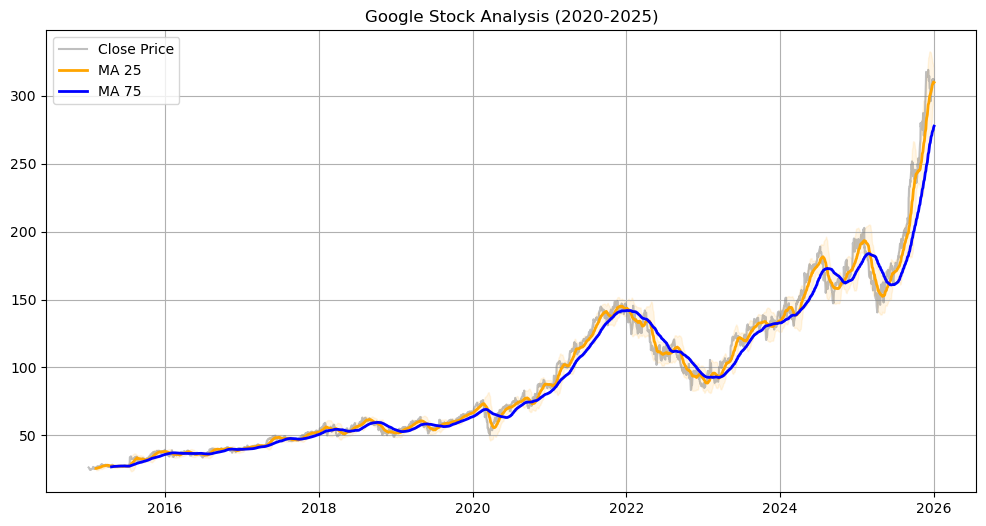

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. データを読み込む
df = pd.read_csv('google.csv')

# 2. 日付を「日付型」に変換して、「インデックス（行の見出し）」にセットする
# ★ここがさっき抜けていたか、リセットされていた重要な部分です！
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 3. 直近5年分（2020年以降）に絞る
# 今、インデックスが日付になったので、この比較が動くようになります！
df_recent = df[df.index >= '2015-01-01'].copy()

# 4. テクニカル指標の計算
df_recent['MA25'] = df_recent['close'].rolling(window=25).mean()
df_recent['MA75'] = df_recent['close'].rolling(window=75).mean()
sigma = df_recent['close'].rolling(window=25).std()
df_recent['Upper'] = df_recent['MA25'] + 2 * sigma
df_recent['Lower'] = df_recent['MA25'] - 2 * sigma

# 5. グラフを描く
plt.figure(figsize=(12, 6))
plt.plot(df_recent.index, df_recent['close'], label='Close Price', color='gray', alpha=0.5)
plt.plot(df_recent.index, df_recent['MA25'], label='MA 25', color='orange', linewidth=2)
plt.plot(df_recent.index, df_recent['MA75'], label='MA 75', color='blue', linewidth=2)
plt.fill_between(df_recent.index, df_recent['Upper'], df_recent['Lower'], color='orange', alpha=0.1)

plt.title('Google Stock Analysis (2020-2025)')
plt.legend()
plt.grid(True)
plt.show()


In [90]:
print(df_recent.head())

                 open       high        low      close  adj_close     volume  \
date                                                                           
2010-01-04  15.566816  15.684434  15.753504  15.621622  15.689439   78169752   
2010-01-05  15.498264  15.615365  15.711712  15.554054  15.695195  120067812   
2010-01-06  15.107573  15.221722  15.662162  15.174174  15.662162  158988852   
2010-01-07  14.755876  14.867367  15.265265  14.831081  15.250250  256315428   
2010-01-08  14.952588  15.065566  15.096346  14.742492  14.814815  188783028   

            MA25  MA75  Upper  Lower  
date                                  
2010-01-04   NaN   NaN    NaN    NaN  
2010-01-05   NaN   NaN    NaN    NaN  
2010-01-06   NaN   NaN    NaN    NaN  
2010-01-07   NaN   NaN    NaN    NaN  
2010-01-08   NaN   NaN    NaN    NaN  


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1940, number of used features: 13
[LightGBM] [Info] Start training from score 0.000742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\hayato\.conda\envs\hanyou\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\hayato\.conda\envs\hanyou\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\hayato\.conda\envs\hanyou\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


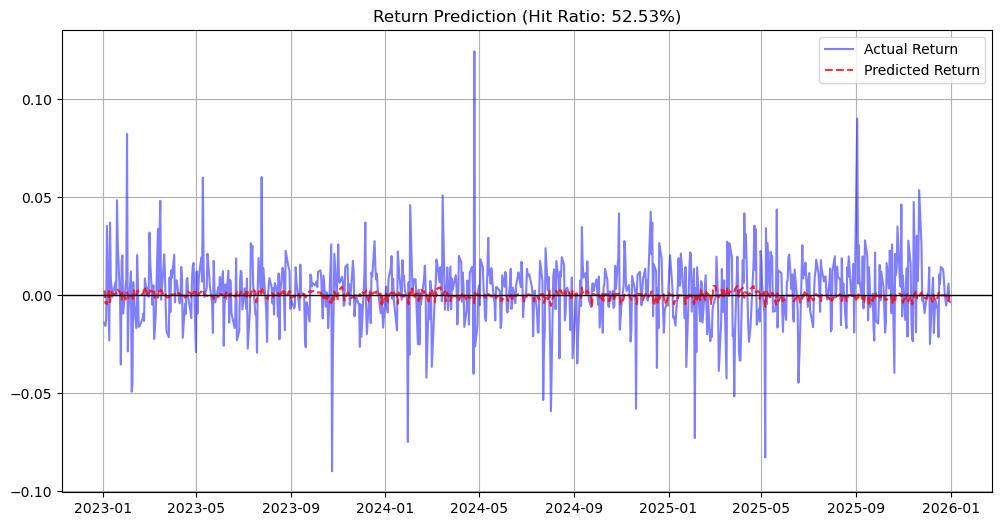

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb 
# --- ここを変えるだけで劇的に変わります！ ---

# 1. 目的変数を「価格」ではなく「対数収益率（変化率）」にする
# pct_change() で「昨日より何%変わったか」を計算します
df_recent['return'] = df_recent['close'].pct_change()

# ターゲットは「翌日の変化率」
df_recent['target'] = df_recent['return'].shift(-1)

# 特徴量にも「過去の変化率（ラグ）」を入れるとヒントになります
df_recent['return_lag1'] = df_recent['return'].shift(1) # 昨日の変化率
df_recent['return_lag2'] = df_recent['return'].shift(2) # 一昨日の変化率
df_recent['return_lag3'] = df_recent['return'].shift(3) # 3日前の変化率
# 1. RSI (短期的な過熱感)
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_recent['RSI'] = calculate_rsi(df_recent['close'])

# 2. MACD (トレンド転換のシグナル)
# EMA（指数平滑移動平均）を使います
ema12 = df_recent['close'].ewm(span=12, adjust=False).mean()
ema26 = df_recent['close'].ewm(span=26, adjust=False).mean()
df_recent['MACD'] = ema12 - ema26
df_recent['Signal'] = df_recent['MACD'].ewm(span=9, adjust=False).mean()

# 3. ボラティリティ（値動きの激しさ）
# 激しい時は大きく動く傾向があるため
df_recent['Volatility'] = df_recent['return'].rolling(window=20).std()

# 4. ラグ特徴量（過去の記憶）
# 昨日、一昨日、3日前の変化率を入れる
df_recent['return_lag1'] = df_recent['return'].shift(1)
df_recent['return_lag2'] = df_recent['return'].shift(2)
df_recent['return_lag3'] = df_recent['return'].shift(3)

# NaNが出るので削除
df_ml = df_recent.dropna().copy()

# 特徴量リストを更新
# ★ここで特徴量をリストにまとめます（全部入り！）
features = [
    'close', 'MA25', 'MA75', 'Upper', 'Lower',        # 元々の特徴量
    'RSI', 'MACD', 'Signal', 'Volatility',            # 新規追加
    'return', 'return_lag1', 'return_lag2', 'return_lag3']
X = df_ml[features]  # 今日のデータ（ヒント）
y = df_ml['target']  # 明日のデータ（正解）
train_mask = X.index < '2023-01-01'
test_mask = X.index >= '2023-01-01'
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]
pipeline = make_pipeline(
    StandardScaler(),
    lgb.LGBMRegressor(random_state=42))
GridSearchCV_params = {
    'lgbmregressor__n_estimators': [100, 300],    # 木の数
    'lgbmregressor__num_leaves': [15, 31, 50],    # 葉の数（複雑さ）
    'lgbmregressor__learning_rate': [0.01, 0.05], # 学習率
    'lgbmregressor__max_depth': [-1, 5, 10]       # 木の深さ
}     # 木の深さ
tscv_grid = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    pipeline, 
    GridSearchCV_params, 
    cv=tscv_grid,  # 👈 ここ！
    scoring='neg_mean_absolute_error',
    n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.2f}")
print("trainscore:", best_model.score(X_train, y_train))
print("testscore:", best_model.score(X_test, y_test))
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1. 「数値」を「プラスかマイナスか」に変換する
# 正解：上がった(True) / 下がった(False)
y_test_direction = y_test > 0
# 予測：上がるて言った(True) / 下がるて言った(False)
y_pred_direction = y_pred > 0

# 2. 方向が一致した確率（正解率）を計算
hit_ratio = accuracy_score(y_test_direction, y_pred_direction)

print(f"方向正解率 (Hit Ratio): {hit_ratio * 100:.2f}%")

# 3. グラフで見てみる
# 予測値（赤）が、0のラインより上にある時に、青い線も上にあればOKです
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Return', alpha=0.5, color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Return', alpha=0.8, color='red', linestyle='--')
plt.axhline(0, color='black', linewidth=1) # 0のライン（基準）
plt.title(f"Return Prediction (Hit Ratio: {hit_ratio:.2%})")
plt.legend()
plt.grid(True)
plt.show()



